# `models_phenom`

In [ ]:
#| default_exp models_phenom

In [ ]:
#| export
import numpy as np
from stochastic.processes.noise import FractionalGaussianNoise as FGN
from andi_datasets.utils_trajectories import gaussian
import warnings

In [ ]:
#| hide
import matplotlib.pyplot as plt
from andi_datasets.utils_trajectories import plot_trajs
%load_ext autoreload
%autoreload 2

#| hide
## Class constructor

In [ ]:
#| export
class models_phenom():
    def __init__(self):
        '''
        This class handles the generation of trajectories from different theoretical models. 
        ''' 
        # We define here the bounds of the anomalous exponent and diffusion coefficient
        self.bound_D = [1e-12, 1e6]
        self.bound_alpha = [0, 1.999]
        
        # We also define the value in which we consider directed motion
        self.alpha_directed = 1.9
        
        # Diffusion state labels: the position of each type defines its numerical label
        # i: immobile/trapped; c: confined; f: free-diffusive (normal and anomalous); d: directed
        self.lab_state = ['i', 'c', 'f', 'd']

# FBM displacements generator

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    
    @staticmethod
    def disp_fbm(alpha : float,
                 D : float,
                 T: int, 
                 deltaT : int = 1):
        ''' Generates normalized Fractional Gaussian noise. This means that, in 
        general:
        
                            <x^2(t)> = 2Dt^alpha
                            
        and in particular:
        
                            <x^2(t = 1)> = 2D 
        
        Parameters
        ----------
        alpha : float in [0,2]
            Anomalous exponent
        D : float
            Diffusion coefficient
        T : int
            Number of displacements to generate
        deltaT : int, optional
            Sampling time
            
        Returns
        -------
        numpy.array
            Array containing T displacements of given parameters
        
        '''
        
        # Generate displacements
        disp = FGN(hurst = alpha/2).sample(n = T)
        # Normalization factor
        disp *= np.sqrt(T)**(alpha)
        # Add D
        disp *= np.sqrt(2*D*deltaT)        
        
        return disp

In [ ]:
show_doc(models_phenom.disp_fbm, name = 'disp_fbm')

### Properties of FBM
The following shows that the generated displacements have the desired properties. Namely, we can choose $D$ and $\alpha$ at will and the function will correctly normalize the displacements. For that, we generate trajectories and estimate parameters of the MSD and VACF from `analysis` class.

In [ ]:
#| hide
from andi_datasets.analysis import msd_analysis, vacf
from tqdm.auto import tqdm

import matplotlib.colors as mcolors

In [ ]:
T = int(2e2)
alphas = np.linspace(0.2, 1.9, 40)
D = 0.5
reps = int(1e4)
tmsd_a = np.zeros((len(alphas), reps))
exp_a = np.zeros((len(alphas), 100))

taus = np.arange(0, 100)
vacf_a = np.zeros((len(alphas[alphas < 1]), len(taus)))

for idx_a, alpha in enumerate(tqdm(alphas)):
    trajs = []
    for rep in range(reps):
        
        disp = models_phenom().disp_fbm(alpha, D, T)
        # Generate trajectory
        traj = np.cumsum(disp)
        trajs.append(traj)        
        # Calculate tMSD(tlag = 1)
        tmsd_a[idx_a, rep] = msd_analysis().tamsd(traj, t_lags = [1]) 
        if rep < 100:                
            # Calculate exponent
            exp_a[idx_a, rep] = msd_analysis().get_exponent(traj)
    
    if alpha < 1:
        trajs = np.vstack(trajs)
        vacf_a[idx_a, :] = vacf(trajs = trajs, delta_t = 1, taus = taus) 

  0%|          | 0/40 [00:00<?, ?it/s]

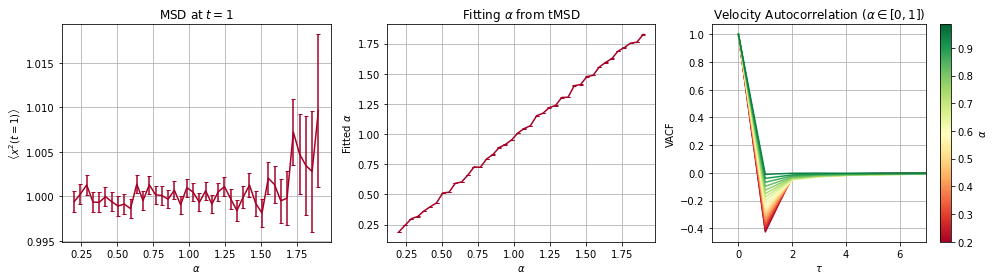

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4), tight_layout = True)

ax[1].errorbar(alphas, exp_a.mean(1), yerr=exp_a.std(1)/np.sqrt(reps), capsize=2, color = plt.cm.RdYlGn(0))
plt.setp(ax[1], ylabel = r'Fitted $\alpha$', xlabel = r'$\alpha$', title = r'Fitting $\alpha$ from tMSD')
ax[1].grid()

ax[0].errorbar(alphas, tmsd_a.mean(1), yerr=tmsd_a.std(1)/np.sqrt(reps), capsize=2, c = plt.cm.RdYlGn(0))
plt.setp(ax[0], ylabel = r'$\left < x^2(t=1) \right>$', xlabel = r'$\alpha$', title = r'MSD at $t=1$')
ax[0].grid()

for idxv, va in enumerate(vacf_a):
    ax[2].plot(taus, va, c = plt.cm.RdYlGn(idxv/vacf_a.shape[0]));
plt.setp(ax[2], xlim = (-1 , 7), xlabel = r'$\tau$', ylabel = 'VACF', title = r'Velocity Autocorrelation ($\alpha\in[0,1]$)')
ax[2].grid()

vec = alphas[alphas < 1]
normalize = mcolors.Normalize(vmin=vec.min(), vmax=vec.max())
colormap = plt.cm.RdYlGn
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(vec)
cbar = fig.colorbar(scalarmappaple, ax = ax[2])
cbar.set_label(r'$\alpha$')

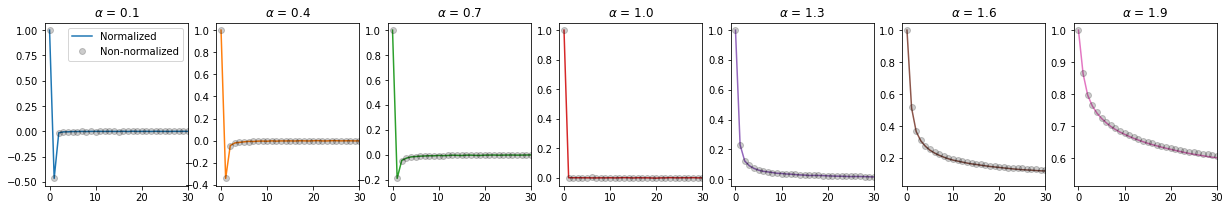

In [ ]:
#| hide
deltats = [1]
taus = np.arange(0, 100)
alphas = np.arange(0.1, 1.91, 0.3)
reps = int(1e4)

fig, ax = plt.subplots(1, len(alphas), figsize = (len(alphas)*3, 3))

for idxa, alpha in enumerate(alphas):
    trajs = np.vstack([np.cumsum(models_phenom().disp_fbm(alpha, D, 200)) for _ in range(reps)])
    trajs_n = np.vstack([np.cumsum(FGN(hurst = alpha/2).sample(n = T)) for _ in range(reps)])

    for deltat in deltats:  
        v = vacf(trajs, deltat, taus)        
        vn = vacf(trajs_n, deltat, taus)        
        ax[idxa].plot(taus/deltat, v.flatten(), '-', c = f'C{idxa}', label = 'Normalized')
        ax[idxa].plot(taus/deltat, vn.flatten(), 'o', alpha = 0.2, c = 'k', label = 'Non-normalized')
        ax[idxa].set_title(fr'$\alpha$ = {np.round(alpha,1)}')
ax[0].legend()   
plt.setp(ax, xlim = (-1, 30));

#| hide
# Sampling diffusion properties 
In some cases, we may need to sample the diffusion parameters of a particle with restrictions on the distribution and distance between parameters of each state. This following function returns the correct values given the necessary contrainsts

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    
    @staticmethod
    def _constraint_alpha(alpha_1, alpha_2, epsilon_a):
        ''' Defines the metric for constraining the changes in anomalous
        exponent'''
        return alpha_1 - alpha_2 < epsilon_a
    
    @staticmethod
    def _constraint_d(d1, d2, gamma_d):
        ''' Defines the metric for constraining the changes in anomalous
        exponent'''
        if gamma_d < 1:
            return d2 > d1*gamma_d
        if gamma_d > 1:
            return d2 < d1*gamma_d
    
    @staticmethod
    def _sample_diff_parameters(alphas : list, # List containing the parameters to sample anomalous exponent in state (adapt to sampling function)
                                Ds : list, # List containing the parameters to sample the diffusion coefficient in state (adapt to sampling function).
                                num_states : int, # Number of diffusive states.
                                epsilon_a : float, #  Minimum distance between anomalous exponents of various states.
                                gamma_d : float, # Factor between diffusion coefficient of various states.
                               ) : 
        '''    
        Given information of the anomalous exponents (alphas), diffusion coefficients (Ds), the function
        samples these from a bounded Gaussian distribution with the indicated constraints (epsilon_a,
        gamma_d). Outputs the list of demanded alphas and Ds.
        
        
        Parameters
        ------------
        alphas : list
        List containing the parameters to sample anomalous exponent in state (adapt to sampling function).
        Ds : list
        List containing the parameters to sample the diffusion coefficient in state (adapt to sampling function).
        num_states : int
        Number of diffusive states.
        epsilon_a : float
        Minimum distance between anomalous exponents of various states.            
                epsilon workflow: we check val[i] - val[i-1] < epsilon
                    if you want that val[i] > val[i-1]: epsilon has to be positive
                    if you want that val[i] < val[i-1]: epsilon has to be negative
                    if you don't care: epsilon = 0
                
        gamma_d : float
        Factor between diffusion coefficient of various states.            
                gamma workflow: 
                    for gamma < 1: val[i] < val[i-1]*gamma
                    for gamma > 1: val[i] > val[i-1]*gamma
                    for gamma = 1: no check
        Returns
        ------------
            :alphas_traj (list): list of anomalous exponents
            :Ds_traj (list): list of diffusion coefficients
                      
        '''

        
        alphas_traj = []
        Ds_traj = []
        for i in range(num_states): 

            # for the first state we just sample normally
            if i == 0:
                alphas_traj.append(float(gaussian(alphas[i], bound = models_phenom().bound_alpha)))
                Ds_traj.append(float(gaussian(Ds[i], bound = models_phenom().bound_D)))
           
            # For next states we take into account epsilon distance between diffusion
            # parameter
            else:
                ## Checking alpha
                alpha_state = float(gaussian(alphas[i], bound = models_phenom().bound_alpha))
                D_state = float(gaussian(Ds[i], bound = models_phenom().bound_D))

                if epsilon_a[i-1] != 0:
                    idx_while = 0
                    while models_phenom()._constraint_alpha(alphas_traj[-1], alpha_state, epsilon_a[i-1]):
                    #alphas_traj[-1] - alpha_state < epsilon_a[i-1]:
                        alpha_state = float(gaussian(alphas[i], bound = models_phenom().bound_alpha))                        
                        idx_while += 1
                        if idx_while > 100: # check that we are not stuck forever in the while loop
                            raise FileNotFoundError(f'Could not find correct alpha for state {i} in 100 steps. State distributions probably too close.')

                alphas_traj.append(alpha_state)
                
                ## Checking D
                if gamma_d[i-1] != 1:    
                    
                    idx_while = 0
                    while models_phenom()._constraint_d(Ds_traj[-1], D_state, gamma_d[i-1]):
                        D_state = float(gaussian(Ds[i], bound = models_phenom().bound_D))
                        idx_while += 1
                        if idx_while > 100: # check that we are not stuck forever in the while loop
                            raise FileNotFoundError(f'Could not find correct D for state {i} in 100 steps. State distributions probably too close.')
               
    
                Ds_traj.append(D_state)
                
        return alphas_traj, Ds_traj

In [ ]:
show_doc(models_phenom._sample_diff_parameters, name = '_sample_diff_parameters')

In [ ]:
models_phenom._sample_diff_parameters(alphas = [[1,0.1]]*2,
                                      Ds = [[1,10]]*2, 
                                      num_states=2, 
                                      epsilon_a = [0.5, 0.01], gamma_d = [2,1])

([1.115597834914795, 0.5914573119483875],
 [2.644760360927501, 7.380304450199705])

We can test that this distances are taken into account when generating trajectories:

In [ ]:
N = 1000; L = 50; T = 2;
epsilon_a=[0.5]; gamma_d = [0.75]
trajs, labels = models_phenom().multi_state(
                                           epsilon_a=epsilon_a, gamma_d = gamma_d, # This is the important part 
                                           T = T, N = N, L = L,
                                           Ds = np.array([[2, 0], [2, 0.2]]), 
                                           alphas = np.array([[1, 0], [0.75, 0.1]]),
                                           return_state_num=True)

Text(0, 0.5, 'Frequency')

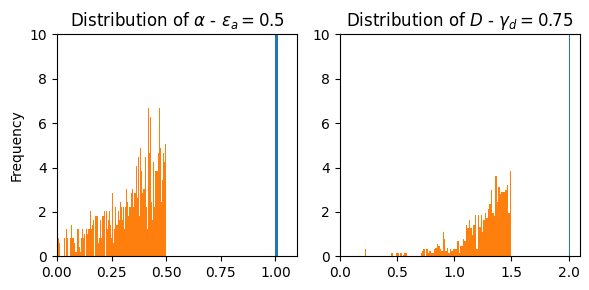

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (6, 3), tight_layout = True)
alphas = labels[:,:,0].flatten()
Ds = labels[:,:,1].flatten()
states_num = labels[:,:,3].flatten()
for s in np.unique(states_num):    
    ax[0].hist(alphas[states_num == s], bins = 100, density = True);
    ax[1].hist(Ds[states_num == s], bins = 100, density = True);
ax[0].set_title(fr'Distribution of $\alpha$ - $\epsilon_a = {epsilon_a[0]}$')
ax[1].set_title(fr'Distribution of $D$ - $\gamma_d = {gamma_d[0]}$')
plt.setp(ax, ylim = [0,10])
ax[0].set_xlim(0,1.1); ax[1].set_xlim(0,2.1)
ax[0].set_ylabel('Frequency')

# Single state model

Particles diffusing according to a single diffusion state, as observed for some lipids in the plasma membrane or for nanoparticles in the cellular environment. 

## Single trajectory generator

In [ ]:
#| hide
#| export
class models_phenom(models_phenom):
    
    @staticmethod
    def _single_state_traj(T :int = 200, 
                          D : float = 1, 
                          alpha : float = 1, 
                          L : float = None,
                          deltaT : int = 1):
        '''
        Generates a single state trajectory with given parameters. 
        
        Parameters
        -----------
        T : int
            Length of the trajectory
        D : float
            Diffusion coefficient       
        alpha : float
            Anomalous exponent
        L : float
            Length of the box acting as the environment
        deltaT : int, optional
            Sampling time
            
        Returns
        ----------
        tuple
            - pos: position of the particle
            - labels:  anomalous exponent, D and state at each timestep. State is always free here.
            
        '''
        
        
        # Trajectory displacements
        dispx, dispy = models_phenom().disp_fbm(alpha, D, T), models_phenom().disp_fbm(alpha, D, T)
        # Labels
        lab_diff_state = np.ones(T)*models_phenom().lab_state.index('f') if alpha < models_phenom().alpha_directed else np.ones(T)*models_phenom().lab_state.index('d')
        labels = np.vstack((np.ones(T)*alpha, 
                            np.ones(T)*D,
                            lab_diff_state
                           )).transpose()

        # If there are no boundaries
        if not L:
            posx, posy = np.cumsum(dispx) - dispx[0], np.cumsum(dispy) - dispy[0]

            return np.vstack((posx, posy)).transpose(), labels

        # If there are, apply reflecting boundary conditions
        else:
            pos = np.zeros((T, 2))

            # Initialize the particle in a random position of the box
            pos[0, :] = np.random.rand(2)*L
            for t in range(1, T):
                pos[t, :] = [pos[t-1, 0]+dispx[t], pos[t-1, 1]+dispy[t]]            


                # Reflecting boundary conditions
                while np.max(pos[t, :])>L or np.min(pos[t, :])< 0: 
                    pos[t, pos[t, :] > L] = pos[t, pos[t, :] > L] - 2*(pos[t, pos[t, :] > L] - L)
                    pos[t, pos[t, :] < 0] = - pos[t, pos[t, :] < 0]

            return pos, labels

In [ ]:
show_doc(models_phenom._single_state_traj, name = '_single_state_traj')

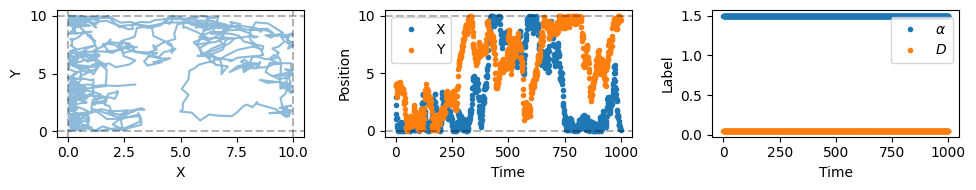

In [ ]:
traj, labels = models_phenom._single_state_traj(D = 0.05,  alpha = 1.5, 
                                                T =1000, L = 10)

fig, ax = plt.subplots(1, 3, figsize = (10, 2), tight_layout = True)
ax[0].plot(traj[:, 0], traj[:, 1], alpha = 0.5)
plt.setp(ax[0], xlabel = 'X', ylabel = 'Y')

ax[1].plot(traj[:, 0], '.', label = 'X')
ax[1].plot(traj[:, 1], '.', label = 'Y', )
plt.setp(ax[1], ylabel = 'Position', xlabel = 'Time')
ax[1].legend()

ax[2].plot(labels[:, 0], '.', label = r'$\alpha$')
ax[2].plot(labels[:, 1], '.', label = r'$D$' )
plt.setp(ax[2], ylabel = 'Label', xlabel = 'Time')
ax[2].legend()

for b in [0,10]:
    ax[0].axhline(b, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(b, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(b, ls = '--', alpha = 0.3, c = 'k')

## Dataset generation

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    
    
    def single_state(self,
                     N:int = 10,
                     T:int = 200, 
                     Ds:list = [1, 0], 
                     alphas:list = [1, 0], 
                     L:float = None):
        '''
        Generates a dataset made of single state trajectories with given parameters.
        
        Parameters
        -----------
        N : int, list
            Number of trajectories in the dataset
        T : int
            Length of the trajectory
        Ds : float
            If list, mean and variance from which to sample the diffusion coefficient. If float, we consider variance = 0.
        alphas : float
            If list, mean and variance from which to sample the anomalous exponent. If float, we consider variance = 0.
        L : float
            Length of the box acting as the environment
        deltaT : int, optional
            Sampling time
            
        Returns
        ----------
        tuple
            - positions: position of the N trajectories.
            - labels:  anomalous exponent, D and state at each timestep. State is always free here.         
        '''

        positions = np.zeros((T, N, 2))
        labels = np.zeros((T, N, 3))

        for n in range(N):
            alpha_traj = gaussian(alphas, bound = self.bound_alpha)
            D_traj = gaussian(Ds, bound = self.bound_D)
            # Get trajectory from single traj function
            pos, lab = self._single_state_traj(T = T, 
                                   D = D_traj, 
                                   alpha = alpha_traj, 
                                   L = L)        
            positions[:, n, :] = pos
            labels[:, n, :] = lab

        return positions, labels

In [ ]:
show_doc(models_phenom.single_state, name = 'single_state')

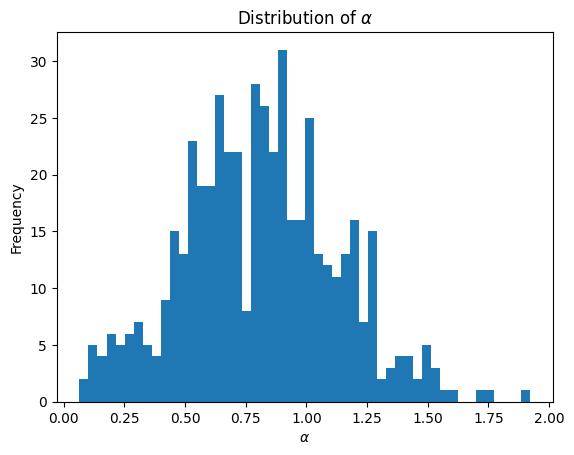

In [ ]:
N = 500; L = 5; T = 100;
alpha = [0.8, 0.1]; D = 1.2

trajs, labels = models_phenom().single_state(N = N,
                                           L = L,
                                           T = T, 
                                           alphas = alpha,
                                           Ds = D)
fig, ax = plt.subplots()
ax.hist(labels[0,:,0], bins = 50)
plt.setp(ax, title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');

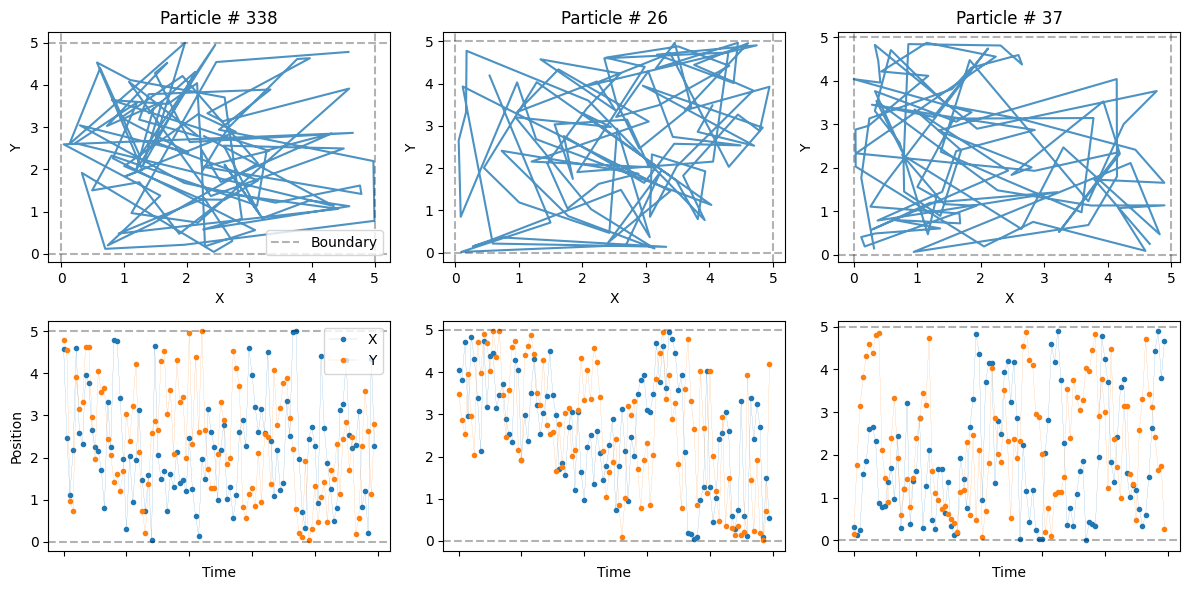

In [ ]:
plot_trajs(trajs, L, N)

# Multiple state model

Particles diffusing according to a time-dependent multi-state (2 or more) model of diffusion, as observed for example in proteins undergoing transient changes of $D$ and/or $\alpha$ as induced by, e.g., allosteric changes or ligand binding.

## Single trajectory generator

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    
    @staticmethod
    def _multiple_state_traj(T = 200, 
                             M = [[0.95 , 0.05],[0.05 ,0.95]], 
                             Ds = [1, 0.1], 
                             alphas = [1, 1], 
                             L = None,
                             deltaT = 1,
                             return_state_num = False, 
                             init_state = None
                            ):
        
        '''
        Generates a 2D multi state trajectory with given parameters.        
        
        Parameters
        ----------
        T : int
            Length of the trajectory
        M : list, array
            Transition matrix between diffusive states.        
        Ds : list
            Diffusion coefficients of the diffusive states. Must have as many Ds as states defined by M.
        alphas : list
            Anomalous exponents of the diffusive states. Must have as many alphas as states defined by M.
        L : float
            Length of the box acting as the environment
        deltaT : int, optional
            Sampling time
        return_state_num : bool
            If True, returns as label the number assigned to the state at each time step.
        init_state : bool
            If True, the particle starts in state 0. If not, sample initial state.
            
            
        Returns
        -------
        tuple
            - pos: position of the particle
            - alphas_t: anomalous exponent at each  step
            - Ds_t: diffusion coefficient at each step. 
            - label_diff_state: particle's state (can be either free or directed for alpha ~ 2) at each step.
            - state (optional): state label at each step.            
        
        '''
        
        # transform lists to numpy if needed
        if isinstance(M, list):
            M = np.array(M)
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)


        pos = np.zeros((T, 2))
        if L: pos[0,:] = np.random.rand(2)*L

        # Diffusing state of the particle
        state = np.zeros(T).astype(int)
        if init_state is None:
            state[0] = np.random.randint(M.shape[0])
        else: state[0] = init_state
        
        # Init alphas, Ds
        alphas_t = np.array(alphas[state[0]]).repeat(T)
        Ds_t = np.array(Ds[state[0]]).repeat(T)
        
        
        # Trajectory displacements    
        dispx, dispy = [models_phenom().disp_fbm(alphas_t[0], Ds_t[0], T),
                        models_phenom().disp_fbm(alphas_t[0], Ds_t[0], T)]


        for t in range(1, T):

            pos[t, :] = [pos[t-1, 0]+dispx[t], pos[t-1, 1]+dispy[t]]  

            # at each time, check new state
            state[t] = np.random.choice(np.arange(M.shape[0]), p = M[state[t-1], :])


            if state[t] != state[t-1]:
                
                alphas_t[t:] =  np.array(alphas[state[t]]).repeat(T-t)  
                Ds_t[t:] = np.array(Ds[state[t]]).repeat(T-t)
                
                
                # Recalculate new displacements for next steps
                if len(dispx[t:]) > 1:                    
                    dispx[t:], dispy[t:] = [models_phenom().disp_fbm(alphas_t[t], Ds_t[t], T-t),
                                            models_phenom().disp_fbm(alphas_t[t], Ds_t[t], T-t)]
                        
                        
                else: 
                    dispx[t:], dispy[t:] = [np.sqrt(2*Ds[state[t]]*deltaT)*np.random.randn(), 
                                            np.sqrt(2*Ds[state[t]]*deltaT)*np.random.randn()]
                    

            if L is not None:
                # Reflecting boundary conditions
                while np.max(pos[t, :])>L or np.min(pos[t, :])< 0: 
                    pos[t, pos[t, :] > L] = pos[t, pos[t, :] > L] - 2*(pos[t, pos[t, :] > L] - L)
                    pos[t, pos[t, :] < 0] = - pos[t, pos[t, :] < 0]
                    
        # Define state of particles based on values of alphas: either free or directed
        label_diff_state = np.zeros_like(alphas_t)
        label_diff_state[alphas_t  < models_phenom().alpha_directed] = models_phenom().lab_state.index('f')
        label_diff_state[alphas_t >= models_phenom().alpha_directed] = models_phenom().lab_state.index('d')
                    
        if return_state_num:            
            return pos, np.array((alphas_t,
                                  Ds_t,
                                  label_diff_state,
                                  state)).transpose()
        else: 
            return pos, np.array((alphas_t,
                                  Ds_t,
                                  label_diff_state)).transpose()
        


In [ ]:
show_doc(models_phenom._multiple_state_traj, name = '_multiple_state_traj')

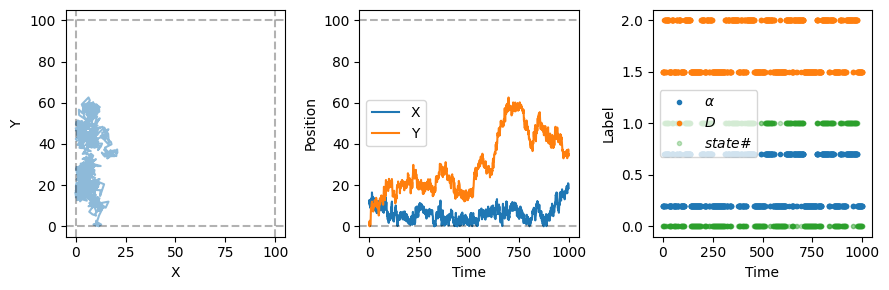

In [ ]:
T = 1000; L = 100
traj, labels = models_phenom._multiple_state_traj(T = T,
                                                  L = L,
                                                  alphas = [0.2, 0.7], 
                                                  Ds = [1.5, 2],                                                  
                                                  return_state_num=True)

fig, ax = plt.subplots(1, 3, figsize = (9, 3), tight_layout = True)
ax[0].plot(traj[:, 0], traj[:, 1], alpha = 0.5)
plt.setp(ax[0], xlabel = 'X', ylabel = 'Y')

ax[1].plot(traj[:, 0], label = 'X')
ax[1].plot(traj[:, 1], label = 'Y', )
plt.setp(ax[1], ylabel = 'Position', xlabel = 'Time')
ax[1].legend()

ax[2].plot(labels[:, 0], '.', label = r'$\alpha$')
ax[2].plot(labels[:, 1], '.', label = r'$D$' )
ax[2].plot(labels[:, 3], '.', label = r'$state \#$', alpha = 0.3 )
plt.setp(ax[2], ylabel = 'Label', xlabel = 'Time')
ax[2].legend()

for b in [0,L]:
    ax[0].axhline(b, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(b, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(b, ls = '--', alpha = 0.3, c = 'k')

## Dataset generation

In [ ]:
#| hide
#| export
class models_phenom(models_phenom):
    def multi_state(self,
                    N = 10,
                    T = 200,
                    M: np.array = [[0.9 , 0.1],[0.1 ,0.9]],
                    Ds: np.array = [[1, 0], [0.1, 0]], 
                    alphas: np.array = [[1, 0], [1, 0]], 
                    gamma_d = [1], 
                    epsilon_a = [0], 
                    L = None,
                    return_state_num = False,
                    init_state = None): 
        '''
        Generates a dataset of 2D multi state trajectory with given parameters.
        
        Parameters
        ----------
        N : int
            Number of trajectories
        T : int
            Length of the trajectory
        M : list, array
            Transition matrix between diffusive states
        Ds : list
            List of means and variances from which to sample the diffusion coefficient of each state. If element size is one, we consider variance = 0.
        alphas : float
            List of means and variances from which to sample the anomalous exponent of each state. If element size is one, we consider variance = 0.   
        gamma_d : list
            Minimum factor between D of diffusive states (see ._sampling_diff_parameters)
        epsilon_a : list
            Distance between alpha of diffusive states (see ._sampling_diff_parameters)
        L : float
            Length of the box acting as the environment
        deltaT : int, optional
            Sampling time
        return_state_num : bool
            If True, returns as label the number assigned to the state at each time step.
        init_state : bool
            If True, the particle starts in state 0. If not, sample initial state.
            
            
        Returns
        -------
        tuple
            - trajs (array TxNx2): particles' position
            - labels (array TxNx2): particles' labels (see ._multi_state for details on labels)           
        
        '''
        
        # transform lists to numpy if needed
        if isinstance(M, list):
            M = np.array(M)
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)
        
        

        trajs = np.zeros((T, N, 2))
        if return_state_num:
            labels = np.zeros((T, N, 4))
        else:
            labels = np.zeros((T, N, 3))

        for n in range(N):
            
            ### Sampling diffusion parameters for each state
            alphas_traj = []
            Ds_traj = []
            
            alphas_traj, Ds_traj = self._sample_diff_parameters(alphas = alphas,
                                                                Ds = Ds,
                                                                num_states = M.shape[0],
                                                                epsilon_a = epsilon_a,
                                                                gamma_d = gamma_d)
                    
            #### Get trajectory from single traj function
            traj, lab = self._multiple_state_traj(T = T,
                                                  L = L,
                                                  M = M,
                                                  alphas = alphas_traj,
                                                  Ds = Ds_traj,
                                                  return_state_num = return_state_num,
                                                  init_state = init_state
                                                 )  
                
            trajs[:, n, :] = traj
            labels[:, n, :] = lab 
            
        return trajs, labels

In [ ]:
show_doc(models_phenom.multi_state, name = 'multi_state')

---

### multi_state

>      multi_state (N=10, T=200, M:<built-infunctionarray>=[[0.9, 0.1], [0.1,
>                   0.9]], Ds:<built-infunctionarray>=[[1, 0], [0.1, 0]],
>                   alphas:<built-infunctionarray>=[[1, 0], [1, 0]],
>                   gamma_d=[1], epsilon_a=[0], L=None, return_state_num=False,
>                   init_state=None)

Generates a dataset of 2D multi state trajectory with given parameters.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| N | int | 10 | Number of trajectories |
| T | int | 200 | Length of the trajectory |
| M | array | [[0.9, 0.1], [0.1, 0.9]] | Transition matrix between diffusive states |
| Ds | array | [[1, 0], [0.1, 0]] | List of means and variances from which to sample the diffusion coefficient of each state. If element size is one, we consider variance = 0. |
| alphas | array | [[1, 0], [1, 0]] | List of means and variances from which to sample the anomalous exponent of each state. If element size is one, we consider variance = 0.    |
| gamma_d | list | [1] | Minimum factor between D of diffusive states (see ._sampling_diff_parameters) |
| epsilon_a | list | [0] | Distance between alpha of diffusive states (see ._sampling_diff_parameters) |
| L | NoneType | None | Length of the box acting as the environment |
| return_state_num | bool | False | If True, returns as label the number assigned to the state at each time step. |
| init_state | NoneType | None | If True, the particle starts in state 0. If not, sample initial state. |
| **Returns** | **tuple** |  | **- trajs (array TxNx2): particles' position<br>- labels (array TxNx2): particles' labels (see ._multi_state for details on labels)           ** |

In [ ]:
N = 100; L = 50; T = 100;

trajs, labels = models_phenom().multi_state(N = N, T = T, L = L,
                                            M = np.array([[0.95 , 0.05],[0.05, 0.95]]),
                                            Ds = np.array([[1, 0], [1, 0.5]]), 
                                            alphas = np.array([[1, 0.01], [0.5, 0.02]]),
                                            epsilon_a=[0.4], gamma_d = [0.75],
                                            return_state_num=True)

We can first check the parameter distributions:

<matplotlib.legend.Legend>

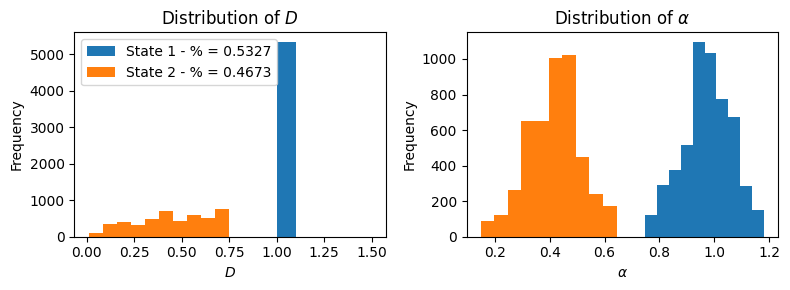

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3), tight_layout = True)

# Diffusion coefficients
ax[0].hist(labels[labels[:,:,3] == 0, 1].flatten(), label = f'State 1 - % = {(labels[:,:,3] == 0).sum()/np.prod(labels.shape[:2])}')
ax[0].hist(labels[labels[:,:,3] == 1, 1].flatten(), label = f'State 2 - % = {(labels[:,:,3] == 1).sum()/np.prod(labels.shape[:2])}')
plt.setp(ax[0], title = r'Distribution of $D$', xlabel = r'$D$', ylabel = 'Frequency');

# Anomalous exponents
ax[1].hist(labels[labels[:,:,3] == 0, 0].flatten(), label = f'State 1 - # = {(labels[:,:,3] == 0).sum()}')
ax[1].hist(labels[labels[:,:,3] == 1, 0].flatten(), label = f'State 2 - # = {(labels[:,:,3] == 1).sum()}')
plt.setp(ax[1], title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');
ax[0].legend()

And then see some examples of trajectories:

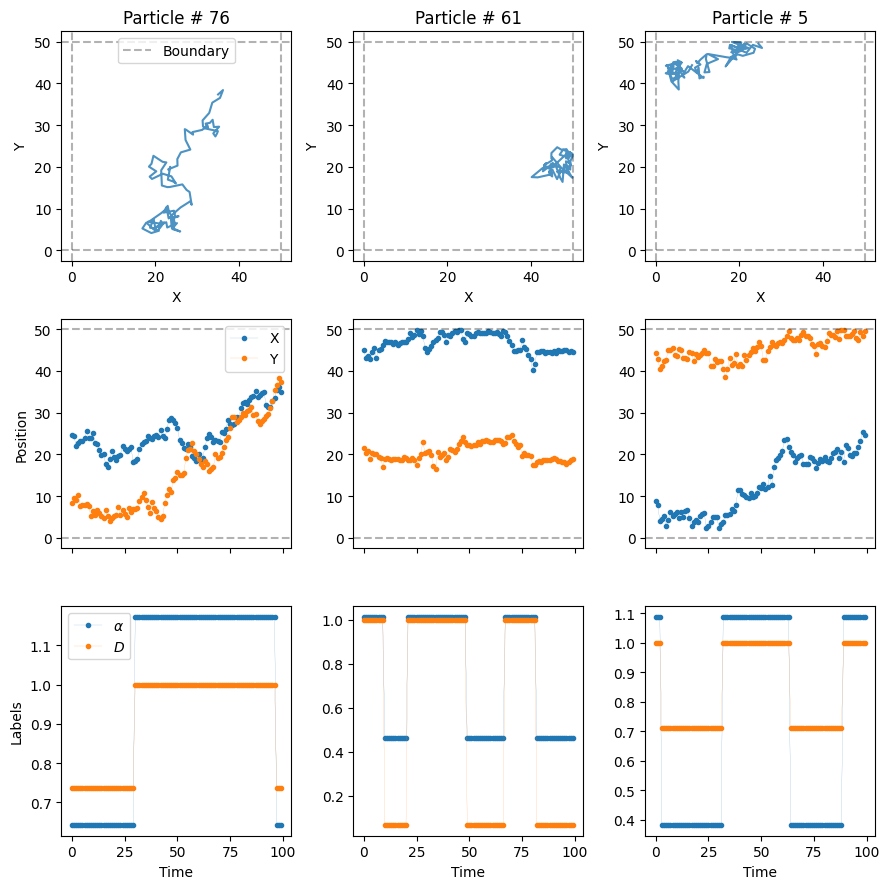

In [ ]:
plot_trajs(trajs, L, N, labels = labels, plot_labels = True)

# Dimerization

Particles diffusing according to a 2-state model of diffusion, with transient changes of $D$ and/or $\alpha$ induced by encounters with other particles, observed for example in protein dimerization.

## Auxiliary functions

**Distance calculator**

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    @staticmethod
    def _get_distance(x):
        '''
        Given a matrix of size Nx2, calculates the distance between the N particles.
        
        Parameters
        ----------
        x : array
            Particles' positions
            
        Returns
        -------
        array
            Distance between particles         
        
        '''
        
        M = np.reshape(np.repeat(x[ :, :], x.shape[0], axis = 0), (x.shape[0], x.shape[0], 2))
        Mtrans = M.transpose(1,0,2)
        distance = np.sqrt(np.square(M[:,:, 0]-Mtrans[:,:, 0])
                         + np.square(M[:,:, 1]-Mtrans[:,:, 1]))  
        return distance

In [ ]:
show_doc(models_phenom._get_distance, name = '_get_distance')

**Escaping dynamics**

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    @staticmethod
    def _make_escape(Pu, label, diff_state):
        ''' 
        Given an unbinding probablity (Pu), the current labeling of particles (label)
        and the current state of particle (diff_state, either bound, 1, or unbound, 0), simulate an
        stochastic binding mechanism. 
        
        Parameters
        ----------
        Pu : float
            Unbinding probablity
        label : array
            Current labeling of the particles (i.e. to which condensate they belong)
        diff_state : array
            Current state of the particles
            
        Returns
        -------
        tuple
            New labeling and diffusive state of the particles        
        
        '''

        # if unbinding probability is zero
        if Pu == 0:
            return label, diff_state

        label = label.copy()
        diff_state = diff_state.copy()

        label_dimers = np.unique(label[np.argwhere(diff_state == 1)])

        for l in label_dimers:         

            if np.random.rand() < Pu:
                # give new label to escaping particles
                diff_state[label == l] = 0
                label[label == l] = np.max(label)+np.arange(2)+1

        return label, diff_state

In [ ]:
show_doc(models_phenom._make_escape, name = '_make_escape')

**Clustering dynamics**

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    @staticmethod
    def _make_condensates(Pb, label, diff_state, r, distance, max_label):
        '''
        Given a binding probability Pb, the current label of particles (label),
        their current diffusive state (diff_state), the particle size (r), their 
        distances (distance) and the label from which binding is not possible 
        (max_label), simulates a binding mechanism.
                
        Parameters
        ----------
        Pb : float
            Binding probablity.
        label : array
            Current labeling of the particles (i.e. to which condensate they belong)
        diff_state : array
            Current state of the particles
        r : float
            Particle size.
        distance : array
            Distance between particles
        max_label : int
            Maximum label from which particles will not be considered for binding
            
        Returns
        -------
        tuple
            New labeling and diffusive state of the particles
        '''

        label = label.copy()
        diff_state = diff_state.copy()

        # Keeping track of the ones that will dimerize
        already_dimer = []

        for n, l in enumerate(label):

            # Consider conditions in which particles do not dimerize
            if n in already_dimer or diff_state[n] == 1 or l > max_label:
                continue

            # Extract distances to current particle
            distance_to_current = distance[n,:]
            distance_to_current[n] == 0
            close_particles = np.argwhere((distance_to_current < 2*r) & (distance_to_current > 0)).flatten()

            # Loop over all posible dimerizing candidates
            for chosen in close_particles:

                # Consider conditions in which particles do not dimerize
                if chosen in already_dimer or diff_state[chosen] == 1 or label[chosen] > max_label: 
                    continue

                # Draw coin to see if particle dimerizes
                if np.random.rand() < Pb:                                 
                    # Add dimerized particles to the new dimer counter
                    already_dimer.append(chosen)
                    already_dimer.append(n)
                    # Update their diffusive state
                    diff_state[n] = 1
                    diff_state[chosen] = 1 

                    # dimerize particles
                    label[chosen] = l

                    # if one particles dimers, not more clustering!
                    break

        return label, diff_state

In [ ]:
show_doc(models_phenom._make_condensates, name = '_make_condensates')

Here is a test in which some particles, distributed randomly through a bounded space, first bind and then unbind using the previous defined functions:

In [ ]:
# Binding and unbinding probabilities
Pb = 0.8; Pu = 0.5
# Generate the particles
N = 200; L = 10; r = 1; max_n = 2; Ds = np.ones(100)
pos = np.random.rand(N, 2)*L    
# Put random labels (label = which condensate you belong). diff_state is zero because all are unbound)
label = np.arange(N)#np.random.choice(range(500), N, replace = False)
diff_state = np.zeros(N).astype(int)
# Define max_label bigger than max of label so everybody binds
max_label = max(label)+2
# Calculate distance between particles
distance = models_phenom._get_distance(pos)

print('# of free particles:')
print(f'Before binding: {len(label)}')

# First make particle bind:
lab, ds = models_phenom._make_condensates(Pb, label, diff_state, r, distance, max_label)
print(f'After binding: {np.unique(lab[np.argwhere(ds == 0)], return_counts=True)[0].shape[0]}')

# Then we do unbinding:
lab, ds = models_phenom._make_escape(Pu, lab, ds)
print(f'After unbinding: {np.unique(lab[np.argwhere(ds == 0)], return_counts=True)[0].shape[0]}')      

# of free particles:
Before binding: 200
After binding: 4
After unbinding: 106


**Stokes drag**

In [ ]:
#| hide
#| export
class models_phenom(models_phenom):
    @staticmethod
    def _stokes(D):
        '''
        Applies a Stokes-Einstein-like transformation to two diffusion coefficients.        
                
        Parameters
        ----------
        D : tuple
            Diffusion coefficients of the two binding particles.
            
        Returns
        -------
        float
            Resulting diffusion coefficient.
        '''
        
        D1 = D[0]; D2 = D[1]
        return 1/((1/D1)+(1/D2))

In [ ]:
show_doc(models_phenom._stokes, name = '_stokes')

## Time evolution

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    def dimerization(self,
                     N = 10,
                     T = 200,                
                     L = 100,
                     r = 1,
                     Pu = 0.1, 
                     Pb = 0.01,
                     Ds: np.array = [[1, 0], [0.1, 0]],
                     alphas: np.array = [[1, 0], [1, 0]],
                     epsilon_a = 0, stokes = False,
                     return_state_num = False,
                     deltaT = 1
                     ):
        '''
        Generates a dataset of 2D trajectories of particles perfoming stochastic dimerization.
        
        Parameters
        ----------
        N : int
            Number of trajectories
        T : int
            Length of the trajectory
        L : float
            Length of the box acting as the environment
        r : float
            Radius of particles.
        Pu : float in [0,1]
            Unbinding probability.
        Pb : float in [0,1])
            Binding probability.    
        Ds : array
            List of means and variances from which to sample the diffusion coefficient of each state. If element size is one, we consider variance = 0.
        alphas : array
            List of means and variances from which to sample the anomalous exponent of each state. If element size is one, we consider variance = 0.   
        epsilon_a : float
            Distance between alpha of diffusive states (see ._sampling_diff_parameters)           
        stokes : bool
            If True, applies a Stokes-Einstein like coefficient to calculate the diffusion coefficient of dimerized particles.  
            If False, we use as D resulting from the dimerization the D assigned to the dimerized state of one of the two particles.
        deltaT : int
            Sampling time
        return_state_num : bool
            If True, returns as label the number assigned to the state at each time step.            
            
        Returns
        -------
        tuple
            - trajs (array TxNx2): particles' position
            - labels (array TxNx2): particles' labels (see ._multi_state for details on labels)
            
        '''
        
        # transform lists to numpy if needed
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)

        # Info to save
        pos = np.zeros((T, N, 2)) # position over time
        label = np.zeros((T, N)).astype(int)
        diff_state = np.zeros((T, N)).astype(int)

        # Init position, labels     
        pos[0, :, :] = np.random.rand(N, 2)*L    
        label[0, :] = np.arange(pos.shape[1])
        
        # Init alphas, Ds
        # Calculate alpha/D for each particle in each state
        alphas_N = np.array([gaussian(alphas[0], size = N, bound = self.bound_alpha),
                             gaussian(alphas[1], size = N, bound = self.bound_alpha)])
        Ds_N = np.array([gaussian(Ds[0], size = N, bound = self.bound_D),
                         gaussian(Ds[1], size = N, bound = self.bound_D)])
        # define labels over time by means of state 0
        alphas_t = alphas_N[0,:].repeat(T).reshape(N,T).transpose()
        Ds_t = Ds_N[0,:].repeat(T).reshape(N,T).transpose()
        
                
        # initial displacements (all free particles)
        disps = np.zeros((T, N, 2))
        for n in range(N):            
            disps[:, n, 0] = models_phenom().disp_fbm(alphas_t[0, n], Ds_t[0, n], T, deltaT = deltaT)
            disps[:, n, 1] = models_phenom().disp_fbm(alphas_t[0, n], Ds_t[0, n], T, deltaT = deltaT)
   
        for t in (range(1, T)):

            # Find max label to account later for escaped
            max_label = np.max(label[t-1, :])

            # Make particles escape
            label[t, :], diff_state[t, :] = self._make_escape(Pu,
                                                              label[t-1, :], 
                                                              diff_state[t-1, :])

            lab, diff = label[t, :].copy(), diff_state[t, :].copy()

            # get distance + increasing it for escaped to avoid reclustering
            distance = self._get_distance(pos[t-1, :, :])

            # Merge particles in condensates
            label[t, :], diff_state[t, :] = self._make_condensates(Pb,
                                                                 label[t, :],
                                                                 diff_state[t, :],
                                                                 r, distance, max_label)

            # Find particles which changed state
            label_changed, counts = np.unique(label[t, np.not_equal(diff_state[t-1,:], diff_state[t,:])], 
                                              return_counts = True)

            # Calculate new displacements for particles which changed state
            for l, count in zip(label_changed, counts):

                index = int(np.argwhere(label[t,:] == l)[0])
                state = diff_state[t, index]
                
                
                ### Calculating new diffusion parameters
                # anomalous exponent
                if epsilon_a != 0 and state == 1:                    
                    new_alpha = gaussian(alphas[1], size = 1, bound = self.bound_alpha)
                    idx_while = 0
                    while models_phenom()._constraint_alpha(alphas_N[0, label[t, :] == l].min(), new_alpha, epsilon_a):
                        new_alpha = gaussian(alphas[1], size = 1, bound = self.bound_alpha)
                        idx_while += 1
                        if idx_while > 100: # check that we are not stuck forever in the while loop
                            raise FileNotFoundError(f'Could not find correct alpha in 100 steps. State distributions probably too close.')
                    alphas_t[t:, label[t, :] == l] = new_alpha
                else: 
                    # if no epsilon is given, use the alpha of the first particle
                    # While here it seems we take both, in the for loop where we assign the displacements below we only
                    # sample with the first value.
                    alphas_t[t:, label[t, :] == l] = alphas_N[state, label[t, :] == l].repeat(T-t).reshape(count, T-t).transpose()
                    
                # diffusion coefficient
                if stokes and state == 1:
                    Ds_t[t:, label[t, :] == l] = models_phenom()._stokes(Ds_t[t-1, label[t, :] == l])
                else: # if no stokes is given, use the D assgined to the dimerized state of the first particle 
                    Ds_t[t:, label[t, :] == l] = Ds_N[state, label[t, :] == l].repeat(T-t).reshape(count, T-t).transpose()
                    
                for idx, i in enumerate(np.argwhere(label[t,:] == l)):
                    # We first calculate the displacements so dimers have same motion
                    if idx == 0:                        
                        if T-t > 1:                       
                            disp_current_x = models_phenom().disp_fbm(float(alphas_t[t, i]), float(Ds_t[t, i]), T-t, deltaT = deltaT).reshape(T-t, 1)
                            disp_current_y = models_phenom().disp_fbm(float(alphas_t[t, i]), float(Ds_t[t, i]), T-t, deltaT = deltaT).reshape(T-t, 1)
                        else: 
                            disp_current_x = np.sqrt(2*float(Ds_t[t, i])*deltaT)*np.random.randn(1)
                            disp_current_y = np.sqrt(2*float(Ds_t[t, i])*deltaT)*np.random.randn(1)
                            
                    disps[t:, i, 0] = disp_current_x
                    disps[t:, i, 1] = disp_current_y

            # Update position
            pos[t, :, :] = pos[t-1,:,:]+disps[t, :, :]
            # Consider boundary conditions
            if L is not None:
                while np.max(pos[t,:, :])>L or np.min(pos[t,:, :])< 0: 
                    pos[t, pos[t,:, :] > L] = pos[t, pos[t,:, :] > L] - 2*(pos[t, pos[t,:, :] > L] - L)
                    pos[t, pos[t,:, :] < 0] = - pos[t, pos[t,:, :] < 0]  
        
        # Define state of particles based on values of alphas: either free or directed            
        label_diff_state = np.zeros_like(alphas_t)
        label_diff_state[alphas_t  < self.alpha_directed] = self.lab_state.index('f')
        label_diff_state[alphas_t >= self.alpha_directed] = self.lab_state.index('d')
        
        if return_state_num:
            return pos, np.array((alphas_t,
                                  Ds_t, 
                                  label_diff_state,
                                  diff_state)).transpose(1,2,0)
        else:
            return pos, np.array((alphas_t,
                                  Ds_t, 
                                  label_diff_state
                                 )).transpose(1,2,0)
    

In [ ]:
show_doc(models_phenom.dimerization, name = 'dimerization')

---

### dimerization

>      dimerization (N=10, T=200, L=100, r=1, Pu=0.1, Pb=0.01, Ds:<built-
>                    infunctionarray>=[[1, 0], [0.1, 0]], alphas:<built-
>                    infunctionarray>=[[1, 0], [1, 0]], epsilon_a=0,
>                    stokes=False, return_state_num=False, deltaT=1)

Generates a dataset of 2D trajectories of particles perfoming stochastic dimerization.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| N | int | 10 | Number of trajectories |
| T | int | 200 | Length of the trajectory |
| L | int | 100 | Length of the box acting as the environment |
| r | int | 1 | Radius of particles. |
| Pu | float | 0.1 | Unbinding probability. |
| Pb | float | 0.01 | Binding probability.     |
| Ds | array | [[1, 0], [0.1, 0]] | List of means and variances from which to sample the diffusion coefficient of each state. If element size is one, we consider variance = 0. |
| alphas | array | [[1, 0], [1, 0]] | List of means and variances from which to sample the anomalous exponent of each state. If element size is one, we consider variance = 0.    |
| epsilon_a | int | 0 | Distance between alpha of diffusive states (see ._sampling_diff_parameters)            |
| stokes | bool | False | If True, applies a Stokes-Einstein like coefficient to calculate the diffusion coefficient of dimerized particles.  <br>If False, we use as D resulting from the dimerization the D assigned to the dimerized state of one of the two particles. |
| return_state_num | bool | False | If True, returns as label the number assigned to the state at each time step.             |
| deltaT | int | 1 | Sampling time |
| **Returns** | **tuple** |  | **- trajs (array TxNx2): particles' position<br>- labels (array TxNx2): particles' labels (see ._multi_state for details on labels)** |

In [ ]:
N = 500; L = 50; r = 1; T = 100
Pu = 0.1 # Unbinding probability
Pb = 1 # Binding probability
# Diffusion coefficients of two states
stokes = True
Ds = np.array([[2, 0.01], [1e-5, 0]]) # because stokes = True, we don't care about the second state
# Anomalous exponents for two states
alphas = np.array([[1, 0], [1, 0.2]]) 

trajs, labels = models_phenom().dimerization(N = N,
                                            L = L,
                                            r = r,
                                            T = T,
                                            Pu = Pu, # Unbinding probability
                                            Pb = Pb, # Binding probability
                                            Ds = Ds, # Diffusion coefficients of two states
                                            alphas = alphas, # Anomalous exponents for two states,
                                            return_state_num = True,
                                            stokes = True, epsilon_a=0.2
                                            )


<matplotlib.legend.Legend>

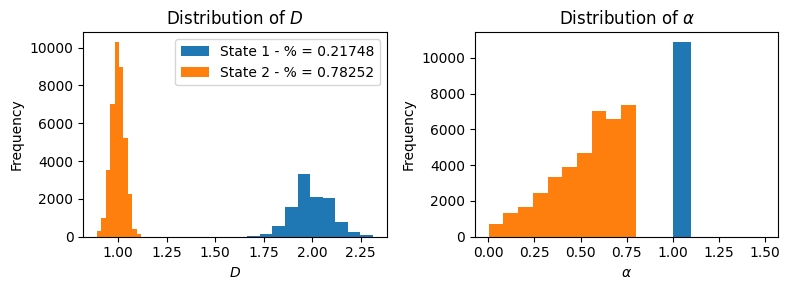

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3), tight_layout = True)

# Diffusion coefficients
ax[0].hist(labels[labels[:,:,3] == 0, 1].flatten(), label = f'State 1 - % = {(labels[:,:,3] == 0).sum()/np.prod(labels.shape[:2])}')
ax[0].hist(labels[labels[:,:,3] == 1, 1].flatten(), label = f'State 2 - % = {(labels[:,:,3] == 1).sum()/np.prod(labels.shape[:2])}')
plt.setp(ax[0], title = r'Distribution of $D$', xlabel = r'$D$', ylabel = 'Frequency');

# Anomalous exponents
ax[1].hist(labels[labels[:,:,3] == 0, 0].flatten(), label = f'State 1 - # = {(labels[:,:,3] == 0).sum()}')
ax[1].hist(labels[labels[:,:,3] == 1, 0].flatten(), label = f'State 2 - # = {(labels[:,:,3] == 1).sum()}')
plt.setp(ax[1], title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');
ax[0].legend()

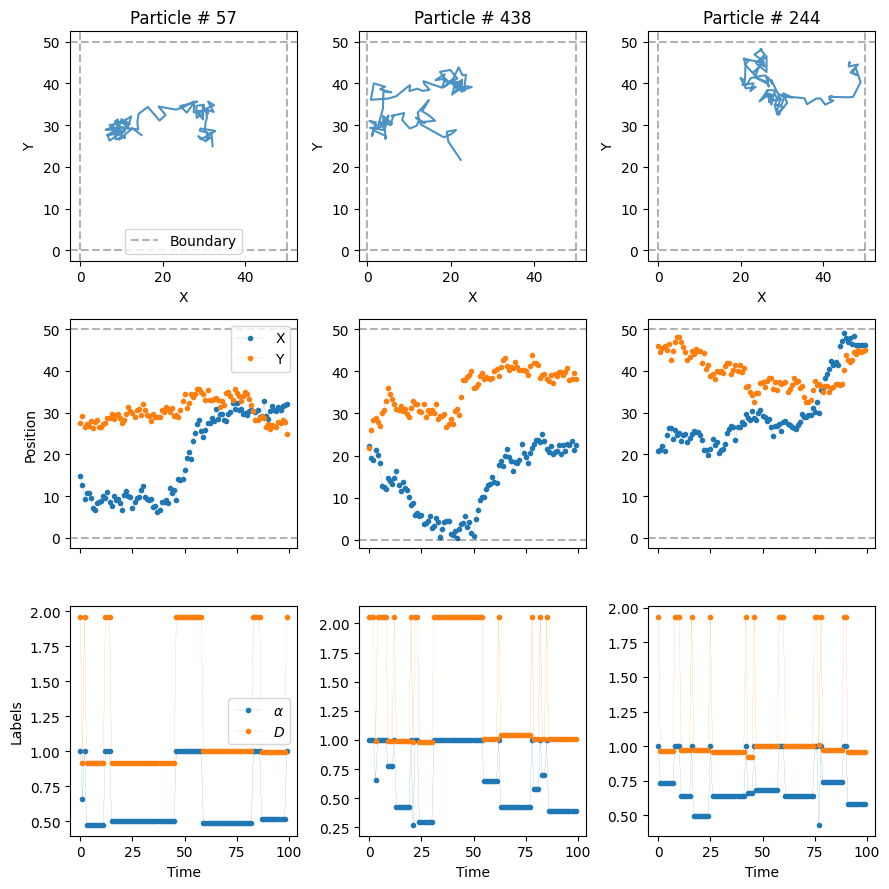

In [ ]:
plot_trajs(trajs, L, N, labels = labels, plot_labels = True)

# Immobile traps

Particles diffusing according to a space-dependent 2-state model of diffusion, representing proteins being transiently immobilized at specific locations as induced by binding to immobile structures, such as cytoskeleton-induced molecular pinning.

In [ ]:
models_phenom._update_bound(

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    @staticmethod
    def _update_bound(mask, # Current binding array
                      N, # Number of particles
                      pos, # Position of particles
                      Nt, # Number of traps
                      traps_pos, # Position of traps
                      Pb, # Binding probability
                      Pu, # Unbinding probability
                      r, # Trap radius
                     ): # Updated binding array
        '''
        Binds and unbinds particles to traps based on their position and binding and unbinding probabilities
        
        Parameters
        ----------
        mask : array
            Current binding array
        N : int
            Number of particles
        pos : array
            Position of particles
        Nt : int
            Number of traps
        traps_pos : array
            Position of traps
        Pb : float in [0,1]
            Binding probability
        Pu : float in [0,1]
            Unbinding probability
        r : float
            Trap radius
            
        Returns
        -------
        array
            Updated binding array
            
        '''

        # from the ones that are bound, get the ones that unbind. These will be descarted for binding in same time step
        mask_new_free = np.array(1-(np.random.rand(N) < Pu)*mask).astype(bool)

        # calculate the distance between traps and particles
        d = models_phenom._get_distance(np.vstack((traps_pos, pos)))[Nt:, :Nt]
        mask_close = (d < r).sum(1).astype(bool)

        # get mask for binding
        mask_new_bind = np.random.rand(N) < Pb

        # update the bound vector with the previous conditions:
        # first, the ones that unbind
        mask *= mask_new_free
        # then, the ones that are close + bind. Mask_new_free is added to avoid binding
        # of the ones that just unbound
        mask += mask_close*mask_new_bind*mask_new_free

        return mask

In [ ]:
show_doc(models_phenom._update_bound, name = '_update_bound')

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):

    def immobile_traps(self,
                       N = 10,
                       T = 200,                
                       L = 100,
                       r = 1,
                       Pu = 0.1, 
                       Pb = 0.01, 
                       Ds = [1, 0], 
                       alphas = [1, 0], 
                       Nt = 10,
                       traps_pos: np.array = None,
                       deltaT = 1
                      ): 
        '''
        Generates a dataset of 2D trajectories of particles diffusing in an environment with immobilizing traps.
        
        Parameters
        ----------
        N : int
            Number of trajectories
        T : int
            Length of the trajectory
        L : float
            Length of the box acting as the environment
        r : float
            Radius of particles.
        Pu : float in [0,1]
            Unbinding probability.
        Pb : float in [0,1])
            Binding probability.    
        Ds : list, float
            Mean and variance from which to sample the diffusion coefficient of the free state. If float, we consider variance = 0
        alphas : list, float
            Mean and variance from which to sample the anomalous exponent of the free state. If float, we consider variance = 0
        Nt : int
            Number of traps
        traps_pos : array, None
            Positions of the traps. Can be given by array or sampled randomly if None.
        deltaT : int
            Sampling time.            
            
        Returns
        -------
        tuple
            - trajs (array TxNx2): particles' position
            - labels (array TxNx2): particles' labels (see ._multi_state for details on labels)
            
        '''

        # Info to output
        pos = np.zeros((T, N, 2)) # position over time
        output_label = np.zeros((T, N, 3))        

        disps = np.zeros((T, N, 2)) 
        diff_state = np.zeros((T, N)).astype(int)
        mask_bound = diff_state[0, :].astype(bool)

        # Init position, labels     
        pos[0, :, :] = np.random.rand(N, 2)*L
        
        # Init alphas, Ds
        # Calculate alpha/D for each particle in state free state
        alphas_N = gaussian(alphas, size = N, bound = self.bound_alpha)
        Ds_N = gaussian(Ds, size = N, bound = self.bound_D)
        
        # Single particle case
        if N == 1:
            alphas_N = [alphas_N]
            Ds_N = [Ds_N]

        # Traps positions
        if traps_pos is None:
            traps_pos = np.random.rand(Nt, 2)*L              
            
        # Get displacement for every particle
        for n in range(N):  
            disps[:, n, 0] = models_phenom().disp_fbm(alphas_N[n], Ds_N[n], T, deltaT = deltaT)
            disps[:, n, 1] = models_phenom().disp_fbm(alphas_N[n], Ds_N[n], T, deltaT = deltaT)
            
        # Set initial values of labels
        output_label[0, :, 0] = alphas_N
        output_label[0, :, 1] = Ds_N

        for t in (range(1, T)):

            mask_bound = self._update_bound(mask = mask_bound, # current bind vector
                                         N = N, # number of particles
                                         pos = pos[t-1, :, :], # position of particles
                                         Nt = Nt, # number of traps
                                         traps_pos = traps_pos, # position of traps
                                         Pb = Pb, # binding probability
                                         Pu = Pu, # unbinding probability
                                         r = r, # trap radius
                                         )
            # Update the diffusive state
            diff_state[t,:] = mask_bound

            # Regenerate trajectories for untrapped particles
            untrapped = np.argwhere((diff_state[t,:] - diff_state[t-1,:]) == -1).flatten()
            for un_part in untrapped:
                    if T-t > 1:
                        # Recalculate new displacements for next steps                        
                        disps[t:, un_part, 0] = models_phenom().disp_fbm(alphas_N[un_part], Ds_N[un_part], T-t, deltaT = deltaT)
                        disps[t:, un_part, 1] = models_phenom().disp_fbm(alphas_N[un_part], Ds_N[un_part], T-t, deltaT = deltaT)

                    else: 
                        disps[t:, un_part, 0] = np.sqrt(2*Ds_N[un_part]*deltaT)*np.random.randn() 
                        disps[t:, un_part, 1] = np.sqrt(2*Ds_N[un_part]*deltaT)*np.random.randn()

            # Update the position
            pos[t, :, :] = pos[t-1, :, :] + (1-mask_bound).reshape(N,1)*disps[t, :, :]

            # Update labels
            output_label[t, :, 0] = alphas_N*(1-mask_bound)
            output_label[t, :, 1] = Ds_N*(1-mask_bound)

            # Consider boundary conditions
            if L is not None:
                while np.max(pos[t,:, :])>L or np.min(pos[t,:, :])< 0: 
                    pos[t, pos[t,:, :] > L] = pos[t, pos[t,:, :] > L] - 2*(pos[t, pos[t,:, :] > L] - L)
                    pos[t, pos[t,:, :] < 0] = - pos[t, pos[t,:, :] < 0]
                    
        # Define state of particles based on values of Ds and alphas. Here, we use the fact 
        # that alpha = 0 for immobilization
        output_label[output_label[:,:,0] == 0, -1] = self.lab_state.index('i')
        idx_f = np.argwhere
        output_label[(output_label[:,:,0] > 0) & (output_label[:,:,0] < self.alpha_directed), -1] = self.lab_state.index('f')
        output_label[output_label[:,:,0] > self.alpha_directed, -1] = self.lab_state.index('d')

        return pos, output_label

In [ ]:
show_doc(models_phenom.immobile_traps, name = 'immobile_traps')

In [ ]:
N = 50; T = 100; L = 100
# Binding and unbinding probs
Pb = 1; Pu = 0.1
# D and alpha
alpha = 1.2
D = [1, 0.2]
# Traps properties
Nt = 100
r = 1
traps_pos = np.random.rand(Nt, 2)*L 

trajs, labels = models_phenom().immobile_traps(N = N, T = T, L = L,
                                               r = r,
                                               Pu = Pu, Pb = Pb, 
                                               Ds = D, alphas = alpha,
                                               Nt = Nt, traps_pos = traps_pos
                                              )

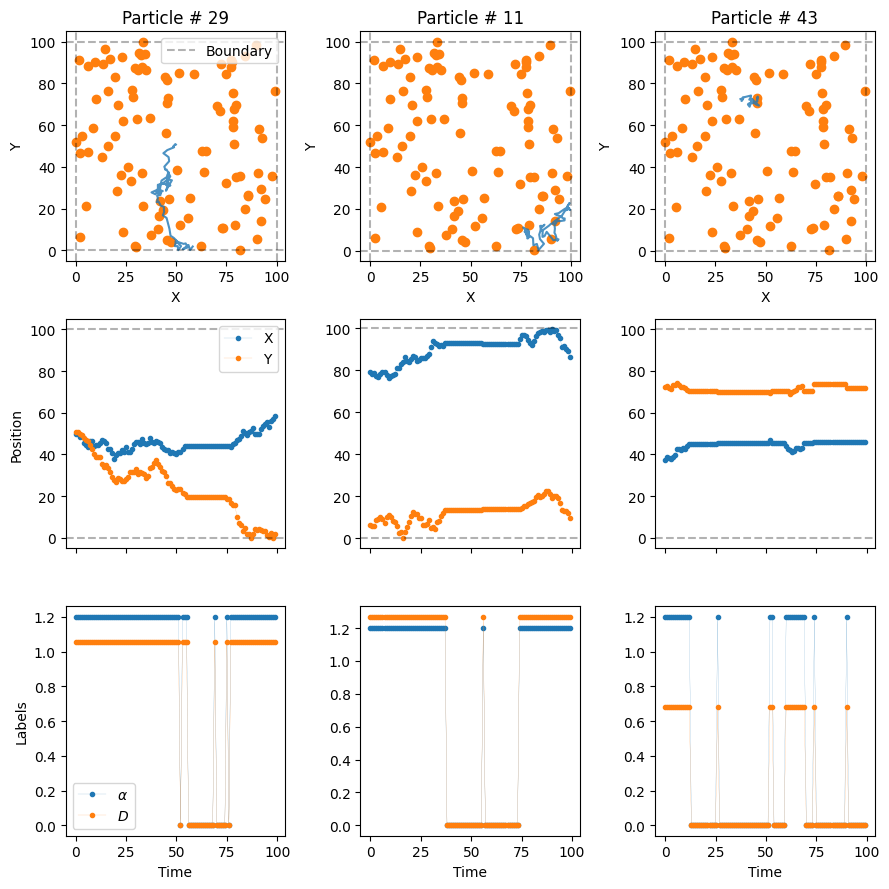

In [ ]:
plot_trajs(trajs, L, N, labels = labels, plot_labels = True, traps_positions=traps_pos)

# Confinement


Particles diffusing according to a space-dependent 2-state model of diffusion, observed for example in proteins being transiently confined in regions where diffusion properties might change, e.g., the confinement induced by clathrin-coated pits on the cell membrane. In the limit of a high density of trapping regions, this model reproduces the picket-and-fence model used to describe the effect of the actin cytoskeleton on transmembrane proteins.

## Auxiliary functions

**Distribute compartments**

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    
    @staticmethod
    def _distribute_circular_compartments(Nc, r, L):
        '''
        Distributes circular compartments over an environment without overlapping. Raises a warning and stops when no more compartments can be inserted.                   
        
        Parameters
        ----------
        Nc : float
            Number of compartments
        r : float
            Size of the compartments
        L : float
            Side length of the squared environment.
            
        Returns
        -------
        array
            Position of the centers of the compartments
        
        '''

        comp_center = np.random.rand(1, 2)*(L - 2*r) + r 
        hardness = 0
        while comp_center.shape[0] < Nc:

            new_pos = np.random.rand(2)*(L - 2*r) + r

            distance = np.linalg.norm(comp_center - new_pos, axis = 1)

            if min(distance) > 2*r:
                comp_center = np.vstack((comp_center, new_pos.reshape(1,2)))

            hardness += 1
            if hardness > Nc*100:
                warn_str = f'Could accomodate {comp_center.shape[0]} circles of the {Nc} requested. Increase size of environment or decrease radius of compartments.'
                warnings.warn(warn_str)
                break
        
        return comp_center

In [ ]:
show_doc(models_phenom._distribute_circular_compartments, name = '_distribute_circular_compartments')

(0.0, 256.0)

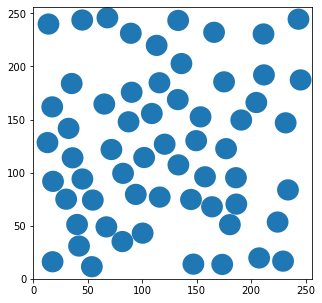

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))

Nc = 60; r = 10; L = 256;
comp_center = models_phenom._distribute_circular_compartments(Nc, r, L)

for c in comp_center:
    circle = plt.Circle((c[0], c[1]), r)
    ax.add_patch(circle)
ax.set_xlim(0,L)
ax.set_ylim(0,L)

**Reflection inside circles**

In [ ]:
#| export
#| hide
from andi_datasets.utils_trajectories import trigo

class models_phenom(models_phenom):
    
    @staticmethod
    def _reflected_position(circle_center, 
                            circle_radius,
                            beg, 
                            end,
                            precision_boundary = 1e-4):
        '''
        Given the begining and end of a segment crossing the boundary of a circle, calculates the new position considering that boundaries are fully reflective.
        
        Parameters
        ----------
        circle_center : float
            Center of the circle            
        circle_radius : float
            Radius of the circle
        beg : tuple
            Position (in 2D) of the begining of the segment
        end : tuple
            Position (in 2D) of the begining of the segment
        precision_boundary : float
            Small area around the real boundary which is also considered as boundary. For numerical stability
            
        Returns
        -------
        tuple
            - Reflected position
            - Intersection point
        
        '''
        
        # If the begining of the segment is in the exact boundary, no intersection is found.
        # In that case, we bring closer the point to the center of the cercle so it is
        # at a distance 'precision_boundary' from the border
        if np.linalg.norm(circle_center - beg) > circle_radius - precision_boundary:
            vec = trigo.seg_to_vec([circle_center, beg])
            beg = np.array(circle_center)+(circle_radius-precision_boundary)*(-np.array(vec)/np.dot(vec, vec)**0.5)
            
        # find the intersection between the line drawn by the displacement and the circle
        intersect = trigo.circle_line_segment_intersection(circle_center = circle_center,
                                                           circle_radius = circle_radius, 
                                                           pt1 = beg,
                                                           pt2 = end)[-1]
        # Draw lines and calculate angles between radius and begining-intersection
        line1 = [circle_center, intersect]
        line2 = [beg, intersect]
        angle = trigo.ang_line(line1, line2)
        # Calculate distance between intersection and end of displacement
        dist_int_end = np.linalg.norm(np.array(intersect) - end)
        # Create radius vector and calculate the tangent vector
        vec_radius = trigo.seg_to_vec([circle_center, intersect])
        tangent = trigo.rotate_vec(vec_radius, np.pi/2) 
        # Calculate the angle between the tangent and the displacement vector
        angle_tan = trigo.ang_vec(tangent, trigo.seg_to_vec([beg, intersect]))
        # Change sign to correct get the reflection
        if angle_tan < np.pi/2: angle = - angle
        # Rotate the radius vector with the reflection angle and normalize by magnitude
        vec_bounce = trigo.rotate_vec(vec_radius, angle)
        vec_bounce /= np.dot(vec_bounce, vec_bounce)**0.5
        # Final point is the previous vector times the distance starting at the intersect point  
        return np.array(intersect)+dist_int_end*np.array(vec_bounce), intersect

In [ ]:
show_doc(models_phenom._reflected_position, name = '_reflected_position')

<matplotlib.legend.Legend>

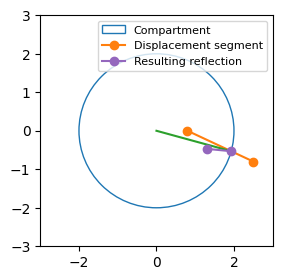

In [ ]:
circle_radius = 2;
circle_center = [0,0]
beg = np.array([0.8, 0])+circle_center
end = np.array([2.5, -0.8])+circle_center

final_point, intersect = models_phenom._reflected_position(circle_center, circle_radius, beg, end)

fig, ax = plt.subplots(figsize = (3, 3))

circle = plt.Circle(circle_center, circle_radius, facecolor = 'w', ec = 'C0', label = 'Compartment', zorder = -1)
ax.add_patch(circle)
ax.plot([beg[0],end[0]], [beg[1], end[1]], '-o', c = 'C1', label = 'Displacement segment')
ax.plot([circle_center[0], intersect[0]], [circle_center[1], intersect[1]], c = 'C2')
ax.plot([intersect[0], final_point[0]], [intersect[1], final_point[1]], '-o', c = 'C4', label = 'Resulting reflection')
ax.set_ylim(circle_center[1]-circle_radius*1.5, circle_center[1]+circle_radius*1.5)
ax.set_xlim(circle_center[0]-circle_radius*1.5, circle_center[0]+circle_radius*1.5)
ax.legend(fontsize = 8)

## Single trajectory generator

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    
    @staticmethod
    def _confinement_traj(T = 200,
                          L = 100,
                          Ds = [1, 0.1],
                          alphas = [1, 1],
                          r = 1,
                          comp_center = None,
                          Nc = 10,
                          trans = 0.1,
                          deltaT = 1):
        '''
        Generates a 2D trajectory of particles diffusing in an environment with partially transmitting circular compartments.
        
        Parameters
        ----------
        T : int
            Length of the trajectory
        L : float
            Length of the box acting as the environment 
        Ds : list
            Diffusion coefficients of the two diffusive states (first free, the confined). Size must be 2.
        alphas : list
            Anomalous exponents of the two diffusive states (first free, the confined). Size must be 2.
        r : float
            Radius of the compartments.             
        comp_center : array, None
            If given, center of the compartments. If None, centers are uniformly sampled.
        Nc : int
            Number of compartments
        trans : float
            Transmittance of the boundaries
        deltaT : int
            Sampling time.            
            
        Returns
        -------
        tuple
            - pos (array Tx2): particle's position
            - labels (array Tx2): particle's labels (see ._multi_state for details on labels)
            
        '''

        
        # transform lists to numpy if needed
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)

        # Traps positions
        if comp_center is None:
            comp_center = models_phenom._distribute_circular_compartments(Nc = Nc,
                                                                          r = r,
                                                                          L = L)
        # Particle's properties
        pos = np.zeros((T, 2)) 
        pos[0,:] = np.random.rand(2)*L

        state = np.zeros(T).astype(int)        
        # Check if particle is compartment
        distance_centers = np.linalg.norm(comp_center - pos[0, :], axis = 1)
        if distance_centers.min() < r:
            # we assign the state to the compartment the particle is on
            compartment = distance_centers.argmin()
            state[0] = 1

        # Output labels
        labels = np.zeros((T, 3))
        labels[0, 0] = alphas[state[0]] 
        labels[0, 1] = Ds[state[0]]         
        

        # Trajectory
        dispx = models_phenom().disp_fbm(alphas[state[0]], Ds[state[0]], T, deltaT = deltaT)
        dispy = models_phenom().disp_fbm(alphas[state[0]], Ds[state[0]], T, deltaT = deltaT)
        disp_t = 0


        for t in range(1, T):
            pos[t, :] = [pos[t-1, 0]+dispx[disp_t], pos[t-1, 1]+dispy[disp_t]]  

            # if the particle was inside a compartment
            if state[t-1] == 1:

                # check if it exited of the compartment
                current_distance = np.linalg.norm(comp_center[compartment, :] - pos[t, :])                              
                if current_distance > r:                    
                    coin = np.random.rand()                    
                    # particle escaping
                    if coin < trans:                        
                        # check that if we entered in a different comparmetn
                        distance_centers = np.linalg.norm(comp_center - pos[t, :], axis = 1)
                        if distance_centers.min() < r:
                            # we assign the state to the compartment the particle is on
                            compartment = distance_centers.argmin()
                            state[t] = 1
                        else: state[t] = 0

                    # particle reflecting
                    else:   
                        beg = pos[t-1, :]
                        while current_distance > r:

                            pos[t, :], intersect = models_phenom._reflected_position(circle_center = comp_center[compartment, :],
                                                                                     circle_radius = r,
                                                                                     beg = beg,
                                                                                     end = pos[t, :])
                            beg = intersect
                            distance_beg = np.linalg.norm(comp_center[compartment, :] - beg)    
                            current_distance = np.linalg.norm(comp_center[compartment, :] - pos[t,:])  
                        state[t] = 1
                # if the particle stayed inside the compartment
                else: state[t] = 1


            # If particle was outside of the compartment
            elif state[t-1] == 0:                
                # Check if particle entered a new compartment
                distance_centers = np.linalg.norm(comp_center - pos[t, :], axis = 1)
                if distance_centers.min() < r:
                    # we assign the state to the compartment the particle is on
                    compartment = distance_centers.argmin()
                    state[t] = 1
                # if the particle stayed outside the comparments
                else: state[t] = 0

            # If the state changed
            if state[t] != state[t-1]:
                
                if T-t > 1:
                    dispx = models_phenom().disp_fbm(alphas[state[t]], Ds[state[t]], T-t, deltaT = deltaT)
                    dispy = models_phenom().disp_fbm(alphas[state[t]], Ds[state[t]], T-t, deltaT = deltaT)
                    
                else: 
                    dispx, dispy = [np.sqrt(2*Ds[state[t]]*deltaT)*np.random.randn(), 
                                    np.sqrt(2*Ds[state[t]]*deltaT)*np.random.randn()]
                disp_t = 0
            # If the state did not change:
            else: disp_t += 1
            
            # Boundary conditions
            if L is not None:
                # Reflecting boundary conditions
                while np.max(pos[t, :])>L or np.min(pos[t, :])< 0: 
                    pos[t, pos[t, :] > L] = pos[t, pos[t, :] > L] - 2*(pos[t, pos[t, :] > L] - L)
                    pos[t, pos[t, :] < 0] = - pos[t, pos[t, :] < 0]


            labels[t, 0] = alphas[state[t]] 
            labels[t, 1] = Ds[state[t]] 
            
        # Define state of particles based on the state array. First free/directed
        if alphas[0] < models_phenom().alpha_directed:
            labels[state == 0, -1] = models_phenom().lab_state.index('f') 
        else:
            labels[state == 0, -1] = models_phenom().lab_state.index('d') 
        # Then confined
        labels[state == 1, -1] = models_phenom().lab_state.index('c')         
        
        return pos, labels
        


In [ ]:
show_doc(models_phenom._confinement_traj, name = '_confinement_traj')

[Text(0.5, 0, 'Position'), Text(0, 0.5, 'Time')]

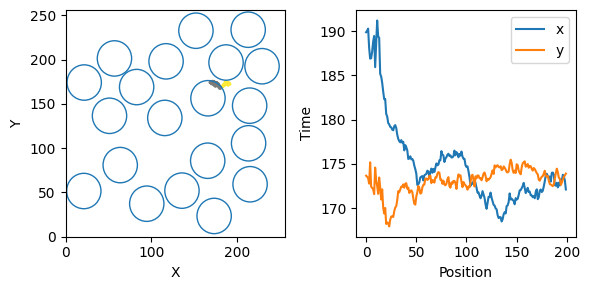

In [ ]:
N = 50;  L = 20
Nc = 15; r = 1; L = 20
Ds = [1, 0.1]
r , L, Nc = (20, 256, 20)

comp_center = models_phenom._distribute_circular_compartments(Nc = Nc, r = r, L = L)
trajs, labels = models_phenom()._confinement_traj(trans = 0.1, Nc = Nc, r = r, L = L, T =200, comp_center=comp_center, Ds = Ds)

fig, axs = plt.subplots(1,2, figsize = (6,3), tight_layout = True)

ax = axs[0]
for c in comp_center:
    circle = plt.Circle((c[0], c[1]), r, facecolor = 'None', edgecolor = 'C0')
    ax.add_patch(circle)    
ax.scatter(trajs[:,0], trajs[:,1], c = plt.cm.cividis(labels[:,-1]/2), zorder = -1, s = 2)   

plt.setp(axs[0], xlim = (0,L), ylim = (0,L), xlabel = 'X', ylabel = 'Y')

axs[1].plot(trajs[:,0], label = 'x');
axs[1].plot(trajs[:,1], label = 'y');
axs[1].legend()
plt.setp(axs[1], xlabel = 'Position', ylabel = 'Time')


## Dataset generation

In [ ]:
#| export
#| hide
class models_phenom(models_phenom):
    def confinement(self,
                    N = 10,
                    T = 200,
                    L = 100,
                    Ds = [[1, 0], [0.1, 0]], 
                    alphas = [[1, 0], [1, 0]],
                    gamma_d = [1], 
                    epsilon_a = [0],
                    r = 1,
                    comp_center = None,
                    Nc = 10,
                    trans = 0.1, 
                    deltaT = 1):
        '''
        Generates a dataset of 2D trajectories of particles diffusing in an environment with partially transmitting circular compartments.
        
        Parameters
        ----------
        N : int
            Number of trajectories
        T : int
            Length of the trajectory
        L : float
            Length of the box acting as the environment 
        Ds : list
            List of means and variances from which to sample the diffusion coefficient of each state. If element size is one, we consider variance = 0.
        alphas : float
            List of means and variances from which to sample the anomalous exponent of each state. If element size is one, we consider variance = 0.       
        gamma_d : list
            Minimum factor between D of diffusive states (see ._sampling_diff_parameters). Size is number of states -1 (in this case size 1)
        epsilon_a : list
            Distance between alpha of diffusive states (see ._sampling_diff_parameters). Size is number of states -1 (in this case size 1)
        r : float
            Radius of the compartments.             
        comp_center : array, None
            If given, center of the compartments. If None, centers are uniformly sampled.
        Nc : int
            Number of compartments
        trans : float
            Transmittance of the boundaries
        deltaT : int
            Sampling time.  
            
        Returns
        -------
        tuple
            - pos (array Tx2): particle's position
            - labels (array Tx2): particle's labels (see ._multi_state for details on labels)
            
        '''
       
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)

        data = np.zeros((T, N, 2))
        labels = np.zeros((T, N, 3))

        for n in range(N):
            
            # Defined physical parameters for each trajectory
            alphas_traj, Ds_traj = self._sample_diff_parameters(alphas = alphas,
                                                                Ds = Ds,
                                                                num_states = 2,
                                                                epsilon_a = epsilon_a,
                                                                gamma_d = gamma_d)

            # Get trajectory from single traj function
            pos, lab = self._confinement_traj(T = T,
                                              Ds = Ds_traj,
                                              alphas = alphas_traj,
                                              L = L,
                                              deltaT = deltaT,
                                              r = r,
                                              comp_center = comp_center,
                                              Nc = Nc,
                                              trans = trans)
            data[:, n, :] = pos
            labels[:, n, :] = lab

        return data, labels

In [ ]:
show_doc(models_phenom.confinement, name = 'confinement')

In [ ]:
N = 50;  L = 20
Nc = 15; r = 1; L = 20
Ds = [[1,0], [150,0.1]]
alphas = [[1, 0], [1.5,0.1]]
r , L, Nc = (20, 256, 15)
comp_center = models_phenom._distribute_circular_compartments(Nc = Nc, r = r, L = L)
trajs, labels = models_phenom().confinement(N = N, L = L, comp_center = comp_center, trans = 0.1, Ds = Ds, 
                                            r = r, alphas = alphas, epsilon_a = [0])

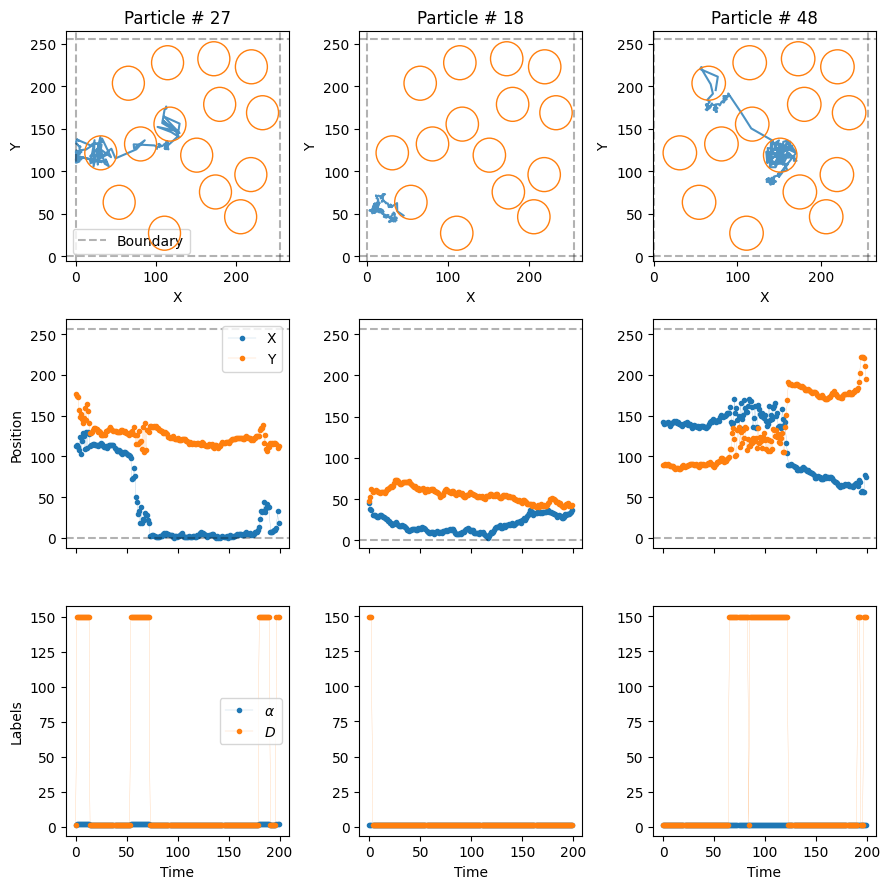

In [ ]:
plot_trajs(trajs, L, N, labels = labels, plot_labels = True, comp_center = comp_center, r_cercle=r)

#| hide
# NBDEV Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()